### This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

### We build photometry emulator

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
import torch

In [3]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [35]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Photulator

In [36]:
photulator = Photulator(n_parameters=2, 
                        filterset=[f'sdss_{i}0' for i in 'ugriz'], 
                        hidden_size=[256, 256, 256])

In [37]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)

phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
phot_all = -2.5 * np.log10(phot_all)
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [38]:
photulator.load_data(phot_all, params, val_frac=0.1, batch_size=128)
train_ind = photulator.dataloaders['train'].dataset.indices
val_ind = photulator.dataloaders['val'].dataset.indices

In [39]:
# for x, y in photulator.dataloaders['val']:
#     break

In [40]:
%%time
n_ep = [200, 100, 150, 500]
for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4]):
    photulator.train(learning_rate=lr, n_epochs=n_ep[i])

Epoch: 0 - train Loss: 0.0084
Epoch: 0 - val Loss: 0.0801
Epoch: 100 - train Loss: 0.0000
Epoch: 100 - val Loss: 0.0000
Epoch: 0 - train Loss: 0.0007
Epoch: 0 - val Loss: 0.0065
Epoch: 0 - train Loss: 0.0001
Epoch: 0 - val Loss: 0.0009
Epoch: 100 - train Loss: 0.0000
Epoch: 100 - val Loss: 0.0000
Epoch: 0 - train Loss: 0.0000
Epoch: 0 - val Loss: 0.0002
Epoch: 100 - train Loss: 0.0000
Epoch: 100 - val Loss: 0.0000
Epoch: 200 - train Loss: 0.0000
Epoch: 200 - val Loss: 0.0000
Epoch: 300 - train Loss: 0.0000
Epoch: 300 - val Loss: 0.0000
Epoch: 400 - train Loss: 0.0000
Epoch: 400 - val Loss: 0.0000
CPU times: user 46 s, sys: 170 ms, total: 46.2 s
Wall time: 46.3 s


In [150]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [41]:
photulator.best_recon_err_epoch

401

In [42]:
photulator.best_loss_epoch

480

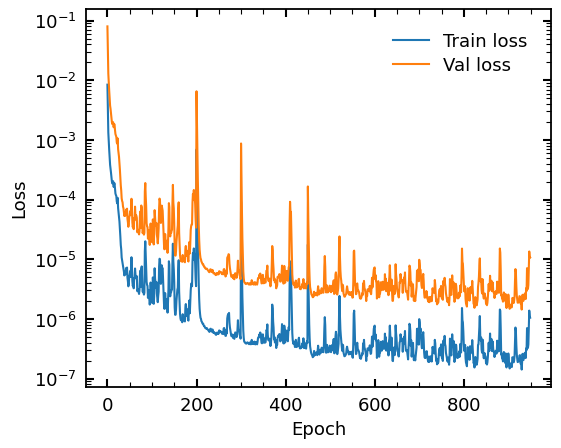

In [43]:
photulator.plot_loss()

In [44]:
ls

best_loss_model_nde_nsf.pkl  best_recon_err_model.pth       test.pkl
best_loss_model.pkl          model.pkl                      train_sed/
best_loss_model.pth          phot_best_loss_model.pkl       train_sed_backup/
best_model.pth               phot_best_recon_err_model.pkl
best_recon_err_model.pkl     sbi-logs/


In [45]:
## Load the NN emulator `speculator`
with open('./phot_best_loss_model.pkl', 'rb') as f:
    photulator = pickle.load(f)

In [47]:
_mags = photulator.predict_mag(params).cpu().detach().numpy()

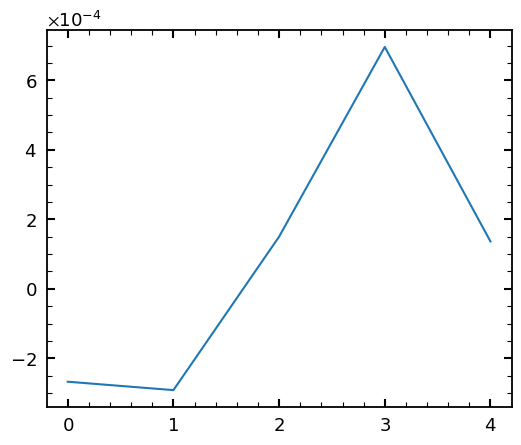

In [48]:
plt.plot(np.median(_mags - phot_all, axis=0))

In [49]:
diff = (phot_all - _mags) / phot_all * 100
diff = diff[val_ind]

In [50]:
from scipy.stats import norm

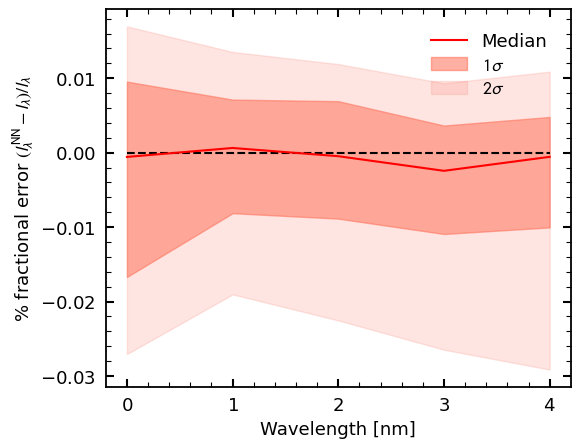

In [54]:
x = np.arange(0, 5, 1)
plt.plot(x, np.median(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 0, 4, ls='--', color='k')
plt.legend()

In [55]:
val_ind[20]

1335

Text(0, 0.5, 'Flux Density (normalized to 1 $M_\\odot$)')

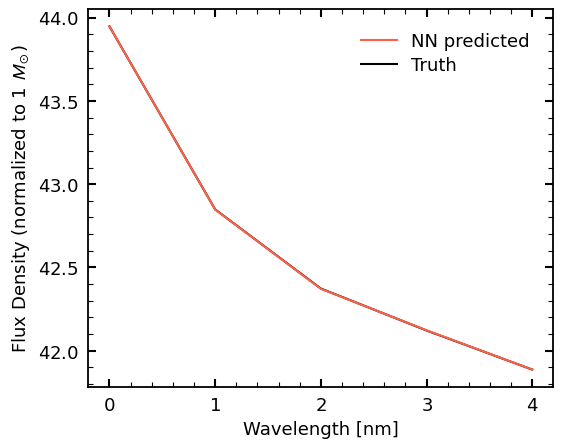

In [56]:
plt.plot(_mags[1335], label='NN predicted', alpha=1, color='tomato', zorder=3)
plt.plot(phot_all[1335], label='Truth', alpha=1, color='k')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel(r'Flux Density (normalized to 1 $M_\odot$)')